<h1 style="font-size: 25px; color: blue;">4 - Breaking down the time series in a $\{Na, K\}$ phase plan</h1>

<br>Contact: guillaumegirier@gmail.com</br>

<br>Commun work: Guillaume Girier, Isa Dallmer-Zerbe, Helmut Schmidt</br>

In this notebook, we analyze the effects of stimulation on the system dynamics by representing the trajectories of the model in the $\{[Na+],[K+]\}$ phase plane. Using the full system equations, we explore the response of the model to stimulation protocols with a chosen amplitude (the user can change the parameter A). Multiple stimulated time series are visualized as arrowed curves, capturing the system's evolution under repeated stimulations, while colormaps provide a detailed representation of a single time series. For clarity, the onset of each stimulation is marked by a dot, and the stimulation duration is highlighted in red.


<h1 style="font-size: 25px; color: blue;">Library importations :</h1>


In [1]:
#%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from matplotlib import cm
import matplotlib as mpl
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

<h1 style="font-size: 25px; color: blue;">Defining functions :</h1>

<h1 style="font-size: 22px; color: red;"> LFES spike train function :</h1>


In [2]:
def generate_periodic_spike_train(total_time, spike_count, dt):
    time = np.arange(0, total_time, dt)
    spike_train = np.zeros_like(time)

    # Calculer les intervalles entre chaque train de spike
    inter_spike_interval = int(1/(dt*Hz))

    # Générer les trains de spikes
    for i in range(spike_count):
        spike_train[i * inter_spike_interval] = 1

    return spike_train

<h1 style="font-size: 22px; color: red;"> Epileptor-2 model function :</h1>


In [3]:
# Epileptor-2 parameter values

Kbath=8.5
gamma=10.0
deltaKo=0.02
deltaNai=0.03
Ko0=3.0
Nai0=10.0

factor = 1.75
tauK=10.0*factor
tauNa=20.0*factor
rho=0.2/factor
taum=0.002  
taux=2.0
deltax=0.01

G_syn=0.3
vmax= 75.0

Vth=10.0

gle=1.0
gKe=0.5

##############################

# Noise activation : 0/1

sigma=0


##############################

# Connection with the inactive population

I0 = 0
Vsyn = -15
Ssyn = 1
gsyn = 0.1686

eps = 1

##############################

# Setting the stimulation time

Hz = 1
A = 30
stim_size = 250
ini_1 = 550
ini_2 = ini_1 + stim_size

##############################

# Define auxiliary functions

def         vi(V): return vmax*1./(1+np.exp(Vth-V))
def    ue(V,xD,Ko): return gKe*26.6*np.log(Ko/Ko0)+G_syn*vi(V)*xD+ sigma * np.random.normal(0, 1) 
def Ipump(Ko,Nai): return rho/((1+np.exp(3.5-Ko))*(1+np.exp((25.0-Nai)/3)))

##############################

# Main function

def my_epileptor_2(t_eval, dt, ini):
    
       
    Ve  = np.zeros(len(t_eval))
    xDe = np.zeros(len(t_eval))
    Koe = np.zeros(len(t_eval))
    Naie = np.zeros(len(t_eval))
    IPUMP = np.zeros(len(t_eval))
    FR = np.zeros(len(t_eval))
    
    I  = np.zeros(len(t_eval))
    
    Ve[0]  =ini[0]
    xDe[0] =ini[1]
    Koe[0] =ini[2]
    Naie[0]=ini[3]
    
    for i in range(1, len(t_eval)):
        
        if statut == True:
            if t_eval[i]>ini_1 and t_eval[i]<ini_2:
                I[i]  = A*Itrain[i]
            else:
                I[i]  = 0
        else:
            I[i]  = 0
            
        
            
        Isyne = gsyn * Ssyn * (Vsyn - Ve[i-1])

        IPUMP[i] = Ipump(Koe[i-1],Naie[i-1])
        FR[i] = vi(Ve[i-1])
        
        Ve[i]  = Ve[i-1] + dt *( (ue(Ve[i-1],xDe[i-1],Koe[i-1])-gle*Ve[i-1]+ Isyne +I[i-1])/taum  )
        xDe[i] = xDe[i-1] + dt *( (1-xDe[i-1])/taux-deltax*xDe[i-1]*vi(Ve[i-1]) )
        Koe[i] = Koe[i-1] + dt * eps * ( (Kbath-Koe[i-1])/tauK-2*gamma*Ipump(Koe[i-1],Naie[i-1])+deltaKo*vi(Ve[i-1]))
        Naie[i]= Naie[i-1] + dt * eps * ( (Nai0-Naie[i-1])/tauNa-3*Ipump(Koe[i-1],Naie[i-1])+deltaNai*vi(Ve[i-1]) )

                
    return np.array([Ve, xDe, Koe, Naie, I, IPUMP, FR])

<h1 style="font-size: 25px; color: blue;">Simulations :</h1>

<h1 style="font-size: 22px; color: red;"> Model without LFES effect simulation :</h1>


In [5]:
S0=np.array([25.0, 0.7, 3.0, 5.0])            # Initial conditions : V, xD, Ko, Na 
t_span = (0, 2000)                            # Time span for simulation
dt=0.001
statut = False                                # Choosing if we apply or not the LFES : True = LFES / False = no LFES
t_eval = np.arange(t_span[0], t_span[1], dt)  # Time points to evaluate
sol = my_epileptor_2(t_eval, dt, S0)          # Simulation


<h1 style="font-size: 22px; color: red;"> Saving the time series into variables:</h1>


In [6]:
VVe_ref = sol[0]
XXe_ref = sol[1]
KKe_ref = sol[2]
NNae_ref = sol[3]
I_ref = sol[4]
T_ref = t_eval

<h1 style="font-size: 22px; color: red;"> Generating the LFES time series to apply :</h1>


In [7]:

# Paramètres
total_time_spike = 20 # Durée totale du train de spikes en secondes
total_time_no = 4  # Durée totale du train de sile en secondes
spike_count = 20*Hz # Nombre de spikes dans chaque train

# Générer le train de spikes
spike_train = generate_periodic_spike_train(total_time_spike, spike_count, dt)



TIME = total_time_spike*2 + total_time_no*0
action_potential_ts = np.hstack((spike_train, spike_train,))

#########################################################

    
for j in range(700):
    TIME += total_time_spike*1 + total_time_no*0
    action_potential_ts = np.hstack((action_potential_ts, np.hstack((spike_train,))))


Itrain = action_potential_ts[:len(t_eval)]
new_TIME = np.arange(0, TIME, dt)[:len(t_eval)]


<h1 style="font-size: 22px; color: red;"> Model with LFES effect simulation :</h1>

Here, several time series are computed with different a different time start for the LFES.
The start values are stocked in the "VALUES_INI" variable.

In [8]:
KK = []
NN = []
VV = []

VALUES_INI = [280, 290, 300, 310, 320]

for VALUE in VALUES_INI :
    stim_size = 250                               # Stimulation size in seconds
    ini_1 = VALUE                                 # Beginning of the stimulation
    ini_2 = ini_1 + stim_size                     # End of the stimulation
    
    S0=np.array([25.0, 0.7, 3.0, 5.0])            # Initial conditions : V, xD, Ko, Na 
    t_span = (0, 2000)                            # Time span for simulation
    dt=0.001
    statut = True                                 # Choosing if we apply or not the LFES : True = LFES / False = no LFES
    t_eval = np.arange(t_span[0], t_span[1], dt)  # Time points to evaluate
    sol = my_epileptor_2(t_eval, dt, S0)          # Simulation

    # Saving in variables:
    VV.append(sol[0])
    KK.append(sol[2])
    NN.append(sol[3])

<h1 style="font-size: 25px; color: blue;">Plotting the multiple time series in $\{Na,K\}$ phase plan :</h1>

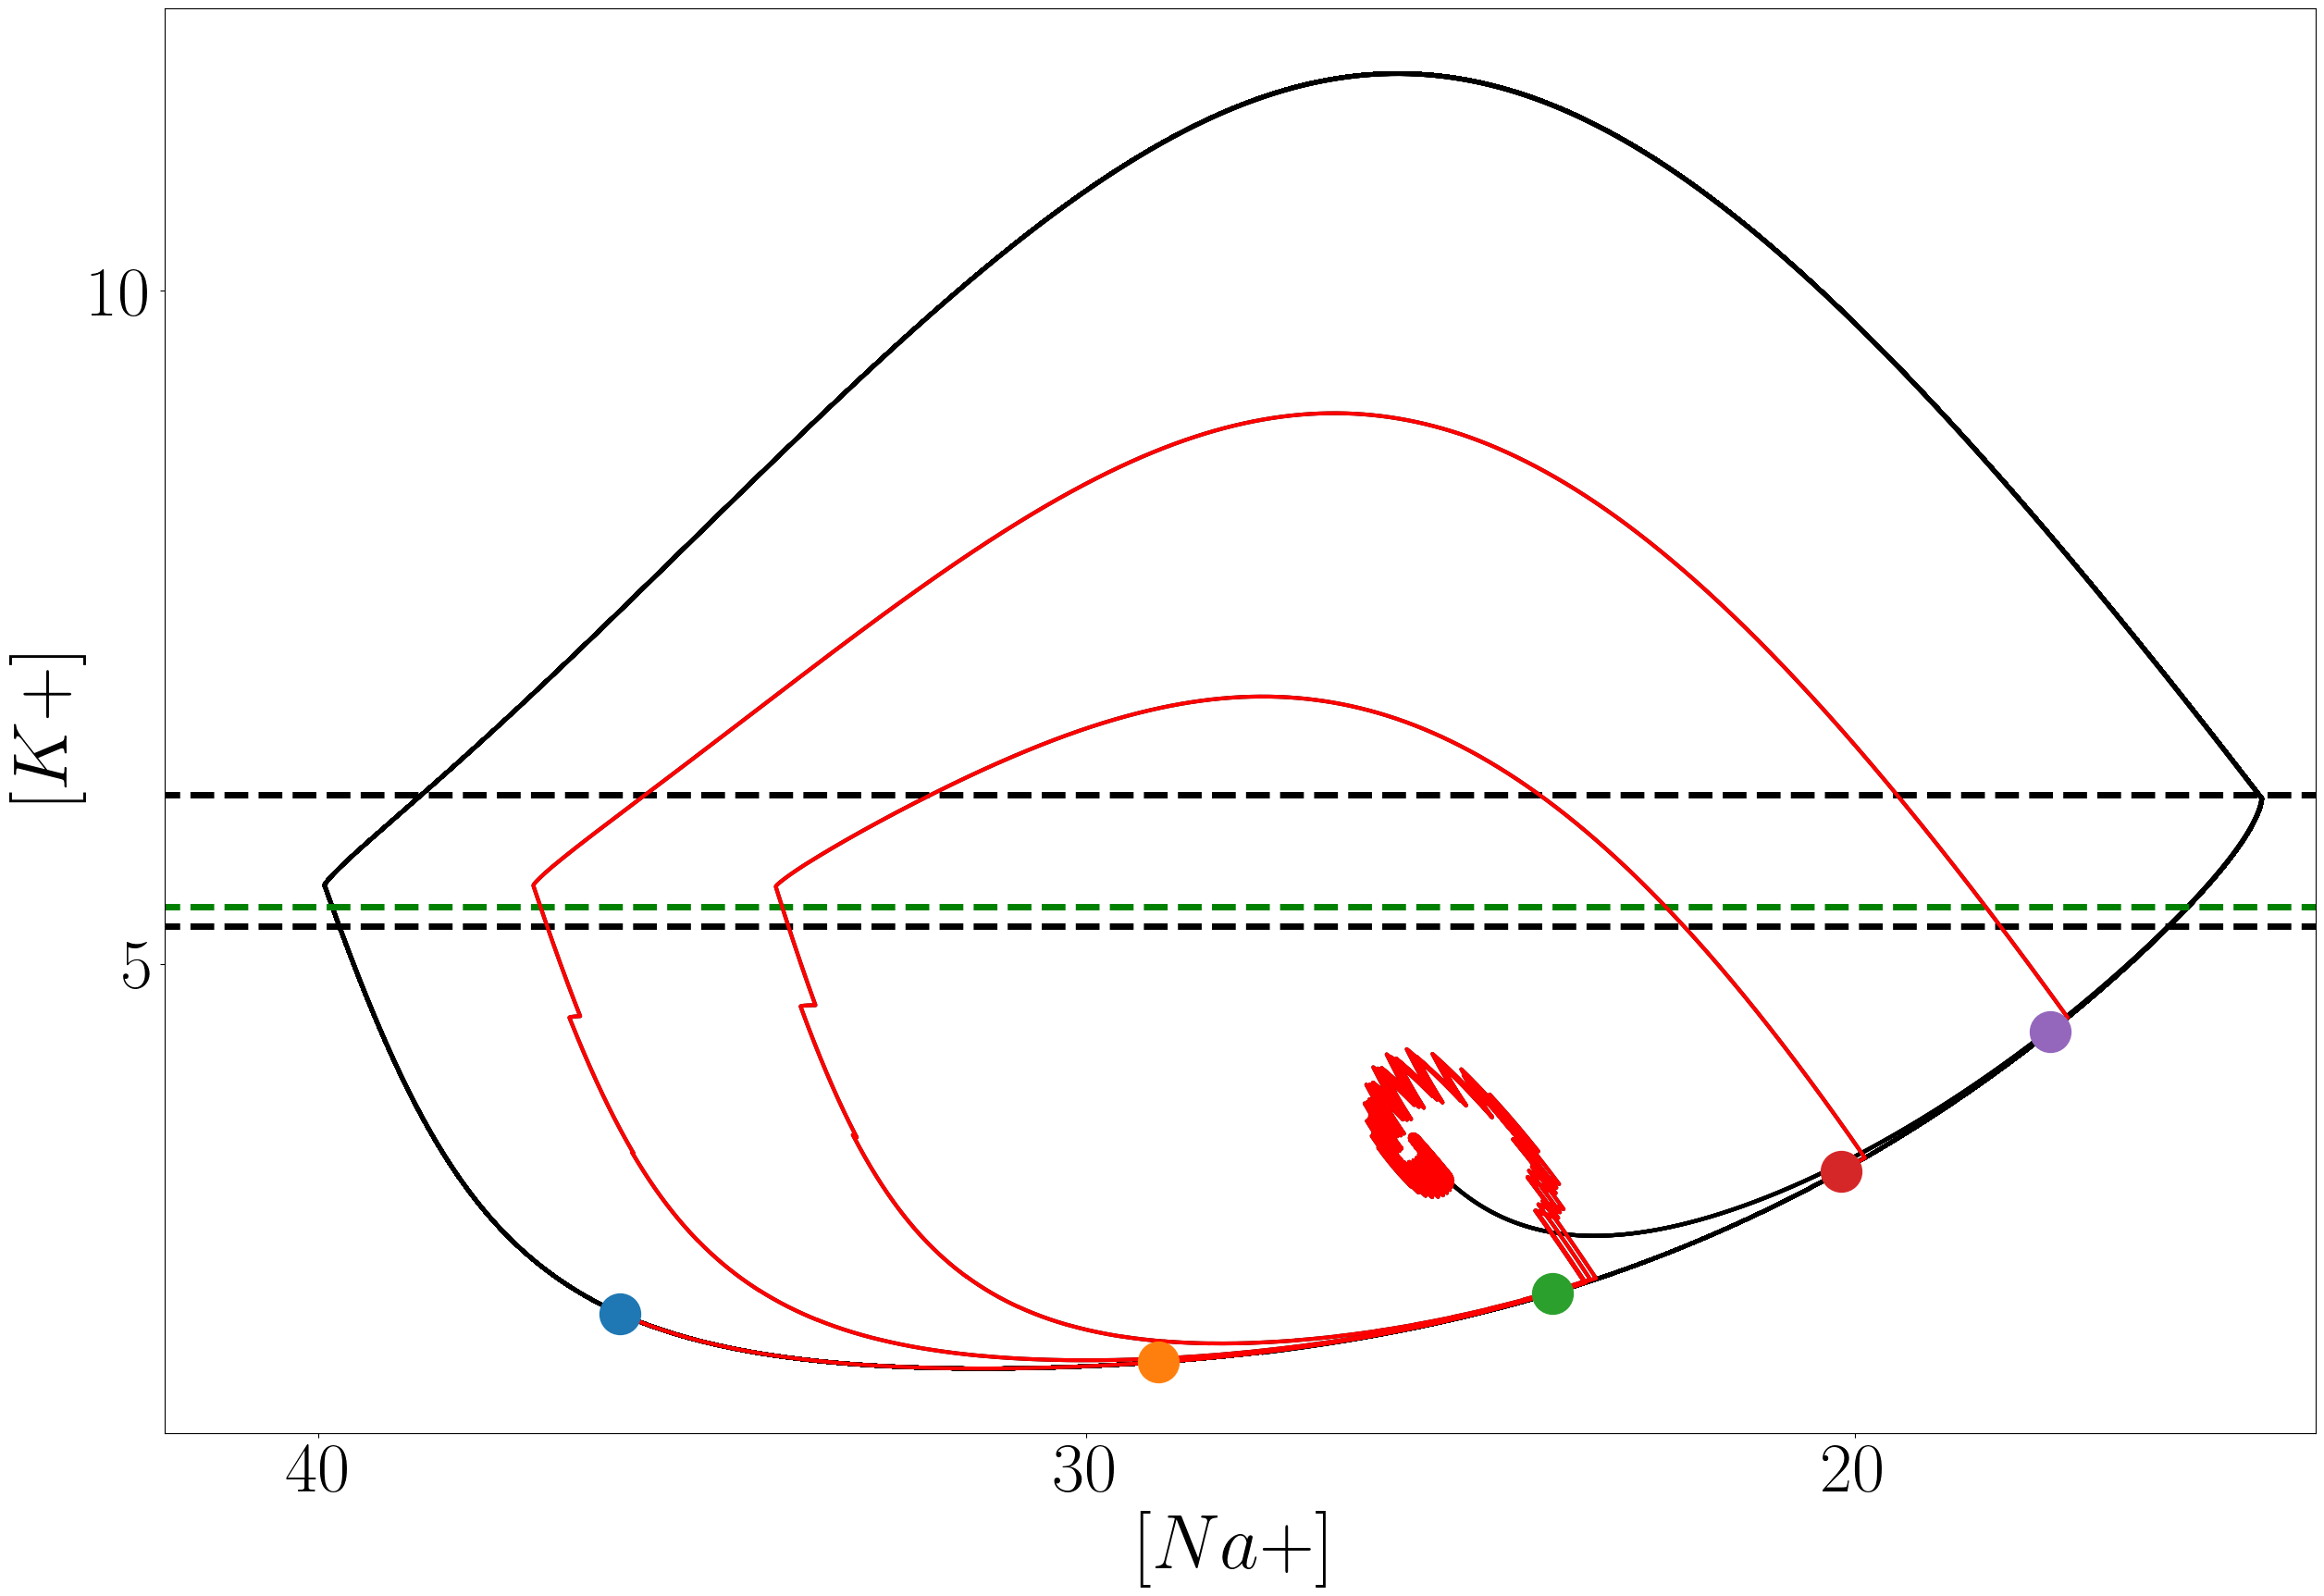

In [10]:
%matplotlib inline

fig = plt.figure(figsize=(30,20)) 
ax = fig.gca()

for i in range(len(NN)):
    plt.plot(NN[i][58000:], KK[i][58000:], c='k', alpha = 1, linewidth = 3)
    plt.plot(NN[i][VALUES_INI[i]*1000:VALUES_INI[i]*1000+stim_size*1000], KK[i][VALUES_INI[i]*1000:VALUES_INI[i]*1000+stim_size*1000], 'r', linewidth=3, zorder=10000)
    plt.scatter(NN[i][VALUES_INI[i]*1000], KK[i][VALUES_INI[i]*1000], s=1000, zorder=20000)


plt.plot(np.linspace(0,50,10), np.ones(10)*5.28, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*6.26, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*5.43, 'g--', linewidth=5)



#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")



plt.rc('text', usetex=True)

plt.xlim([14, 42])
#plt.ylim([0,25])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
ax.xaxis.set_inverted(True) 
xLabel = ax.set_xlabel('$[Na+]$', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('$[K+]$',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.savefig('FIG_5_A3.eps', format='eps', dpi=300)
plt.show()

<h1 style="font-size: 25px; color: blue;">Producing the color maps :</h1>

<h1 style="font-size: 22px; color: red;"> Recomputing the LFES time series :</h1>


In [49]:

# Paramètres
total_time_spike = 20 # Durée totale du train de spikes en secondes
total_time_no = 4  # Durée totale du train de sile en secondes
spike_count = 20*Hz # Nombre de spikes dans chaque train

# Générer le train de spikes
spike_train = generate_periodic_spike_train(total_time_spike, spike_count, dt)



TIME = total_time_spike*2 + total_time_no*0
action_potential_ts = np.hstack((spike_train, spike_train,))

#########################################################

    
for j in range(700):
    TIME += total_time_spike*1 + total_time_no*0
    action_potential_ts = np.hstack((action_potential_ts, np.hstack((spike_train,))))


Itrain = action_potential_ts[:len(t_eval)]
new_TIME = np.arange(0, TIME, dt)[:len(t_eval)]

<h1 style="font-size: 22px; color: red;"> Computing a single time series and stocking all the possible time series :</h1>

The parameter A is the one which can be tuned to change the amplitude of the given signal.
In the paper, we propose A = 20mA, A = 30mA and A = 60mA.

In [50]:
# Initialisation of the storage variables :

VV = []
KK = []
NN = []
XD = []
IPUMP = []
FR = []

VALUES_INI = [280,]

for VALUE in VALUES_INI :
    A = 60                                        # Amplitude of the LFES
    stim_size = 350                               # Stimulation size in seconds
    ini_1 = VALUE                                 # Beginning of the stimulation
    ini_2 = ini_1 + stim_size                     # End of the stimulation
    
    S0=np.array([25.0, 0.7, 3.0, 5.0])            # Initial conditions : V, xD, Ko, Na 
    t_span = (0, 2000)                            # Time span for simulation
    dt=0.001
    statut = True                                 # Choosing if we apply or not the LFES : True = LFES / False = no LFES
    t_eval = np.arange(t_span[0], t_span[1], dt)  # Time points to evaluate
    sol = my_epileptor_2(t_eval, dt, S0)          # Simulation

    # Saving the data : 
    VV.append(sol[0])
    XD.append(sol[1])
    KK.append(sol[2])
    NN.append(sol[3])
    IPUMP.append(sol[5])
    FR.append(sol[6])

<h1 style="font-size: 25px; color: blue;">Plotting the results :</h1>

<h1 style="font-size: 22px; color: red;"> xD color map :</h1>


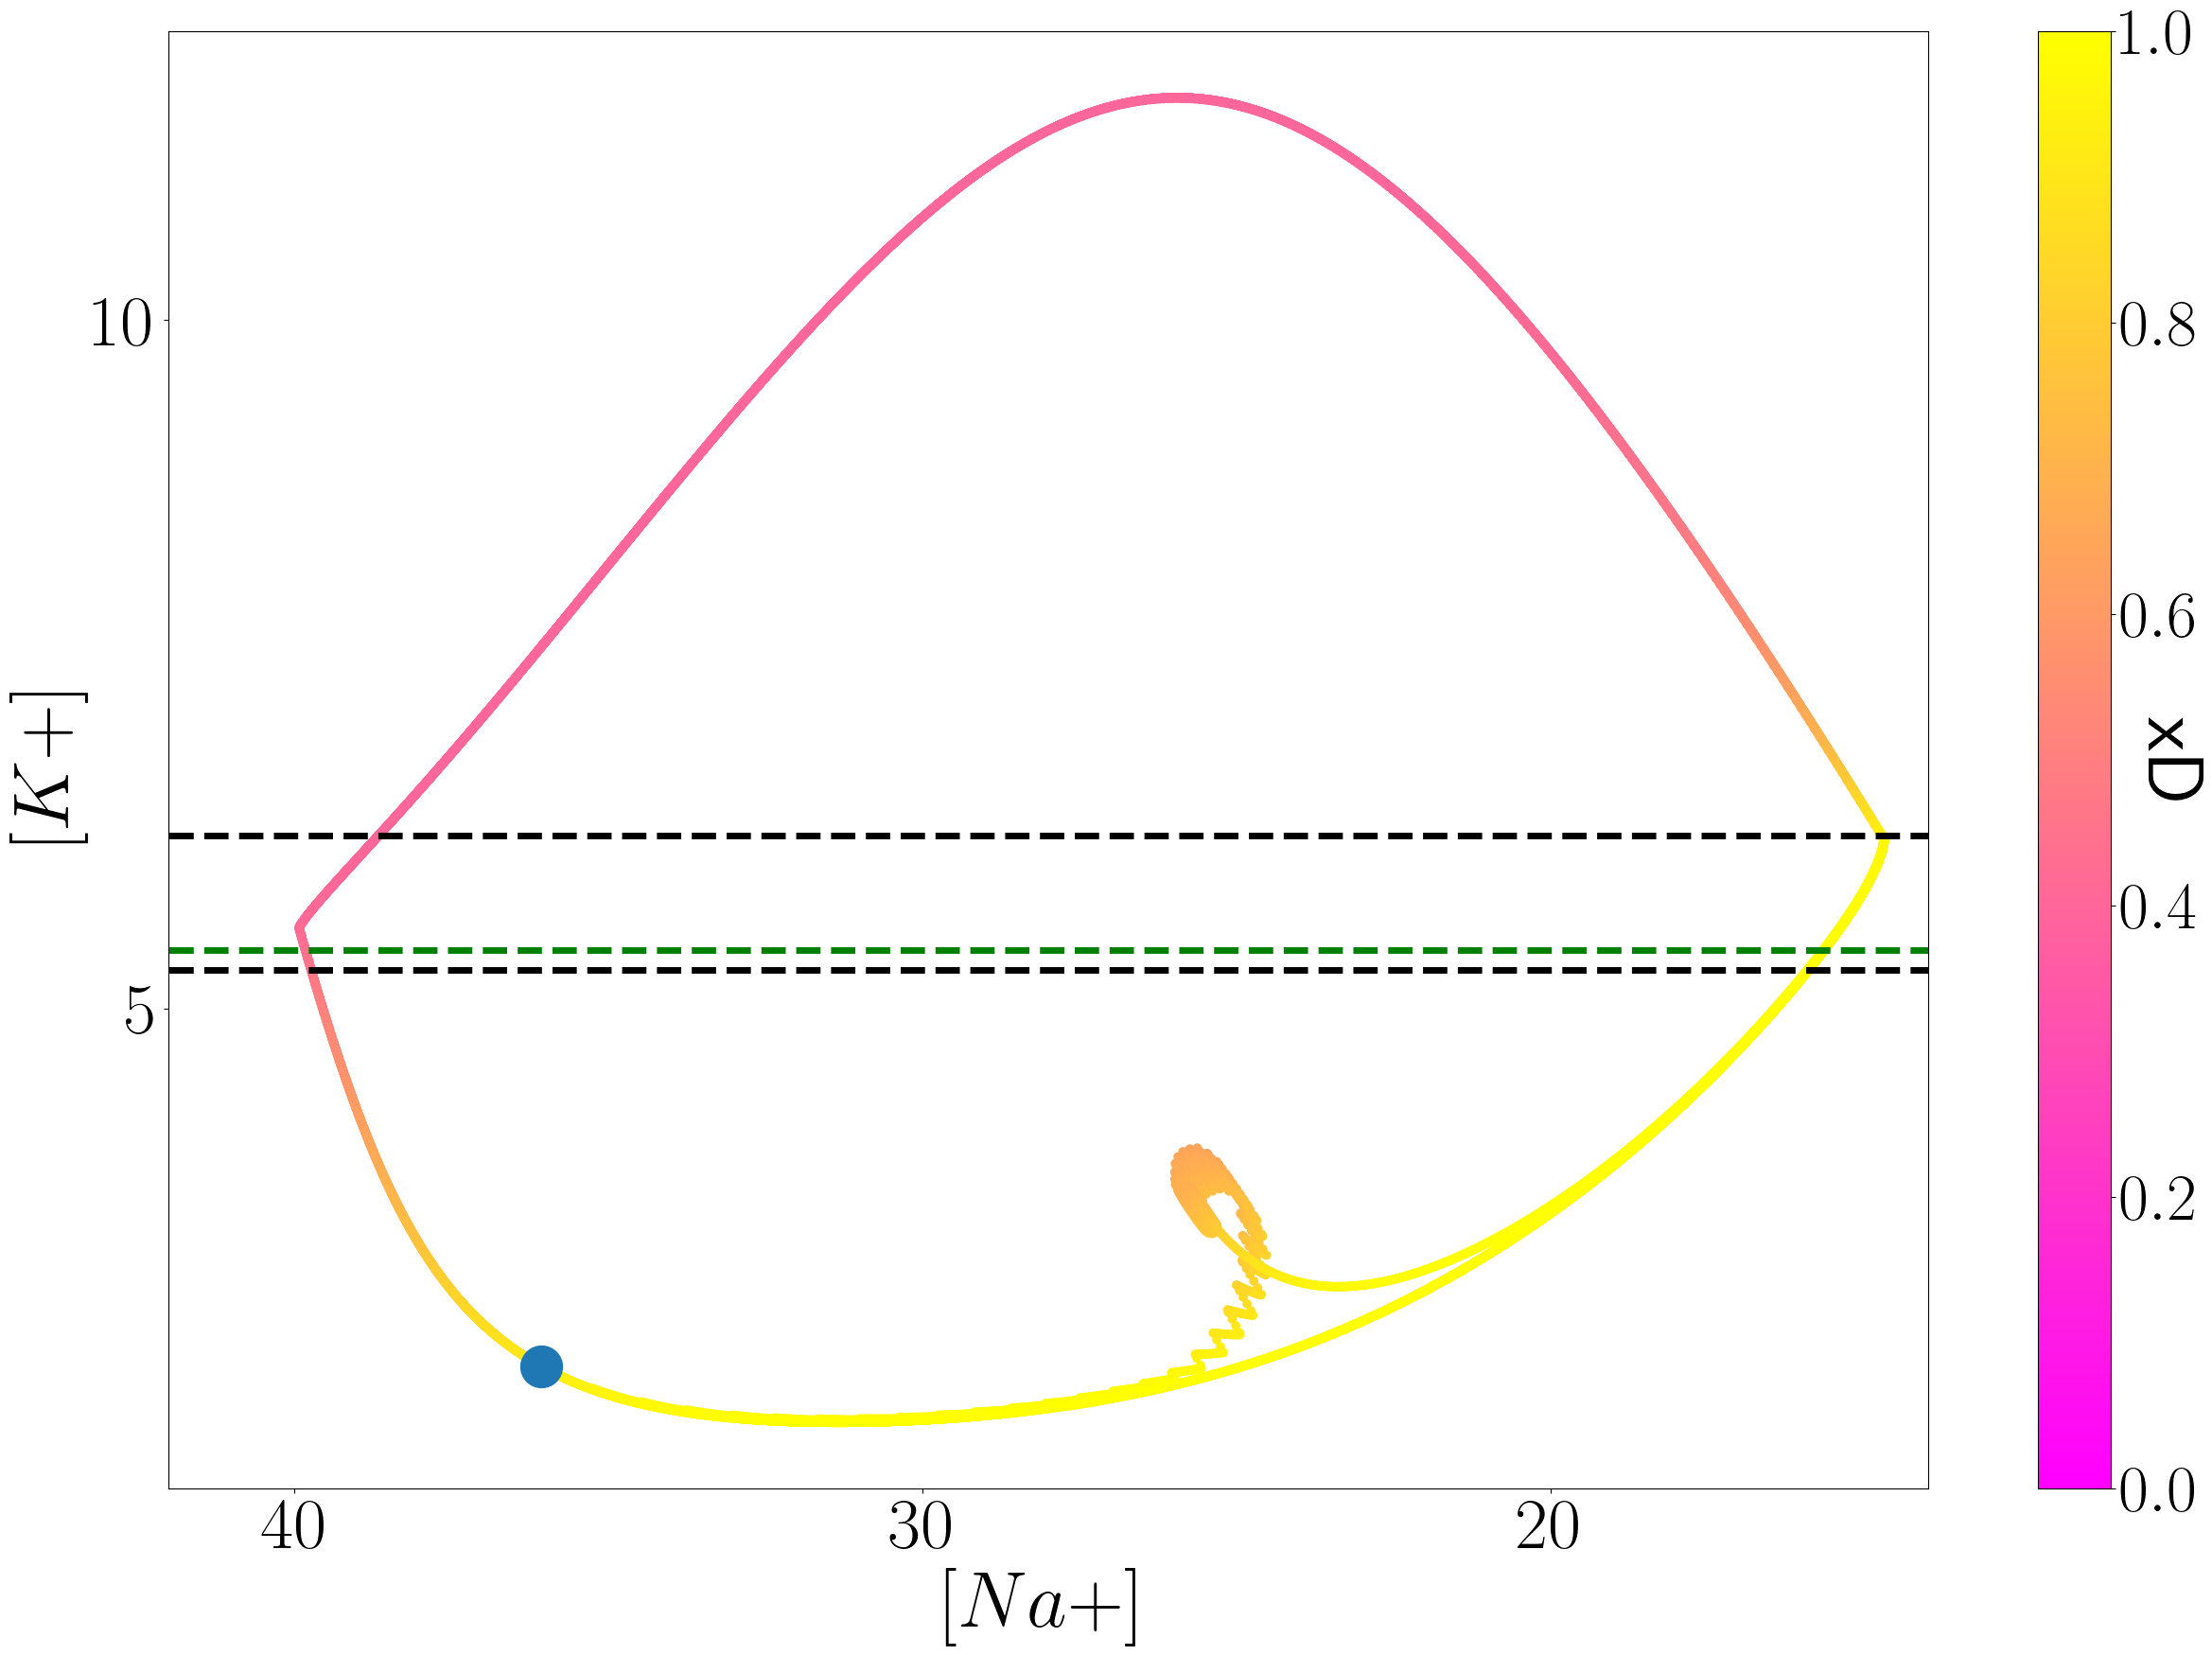

In [51]:
%matplotlib inline

fig = plt.figure(figsize=(30,20)) 
ax = fig.gca()

cmap = plt.get_cmap('spring')
norm = mpl.colors.Normalize(vmin=np.min(XD), vmax=np.max(XD))

for i in range(len(NN)):
    plt.scatter(NN[i][58000:][::35], KK[i][58000:][::35], color=cmap((XD[i][58000:][::35])), alpha = 1, )
    plt.scatter(NN[i][VALUES_INI[i]*1000], KK[i][VALUES_INI[i]*1000], s=1000, zorder=20000)

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),
    ax=plt.gca()
)
cbar.ax.tick_params(labelsize=50)
cbar.ax.set_ylabel('xD', rotation=270, fontsize=60)

plt.plot(np.linspace(0,50,10), np.ones(10)*5.28, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*6.26, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*5.43, 'g--', linewidth=5)



#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")



plt.rc('text', usetex=True)

plt.xlim([14, 42])
#plt.ylim([0,25])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
ax.xaxis.set_inverted(True) 
xLabel = ax.set_xlabel('$[Na+]$', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('$[K+]$',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.savefig('FIG_5_B3.eps', format='eps', dpi=300)
plt.show()

<h1 style="font-size: 22px; color: red;"> Ipump color map :</h1>


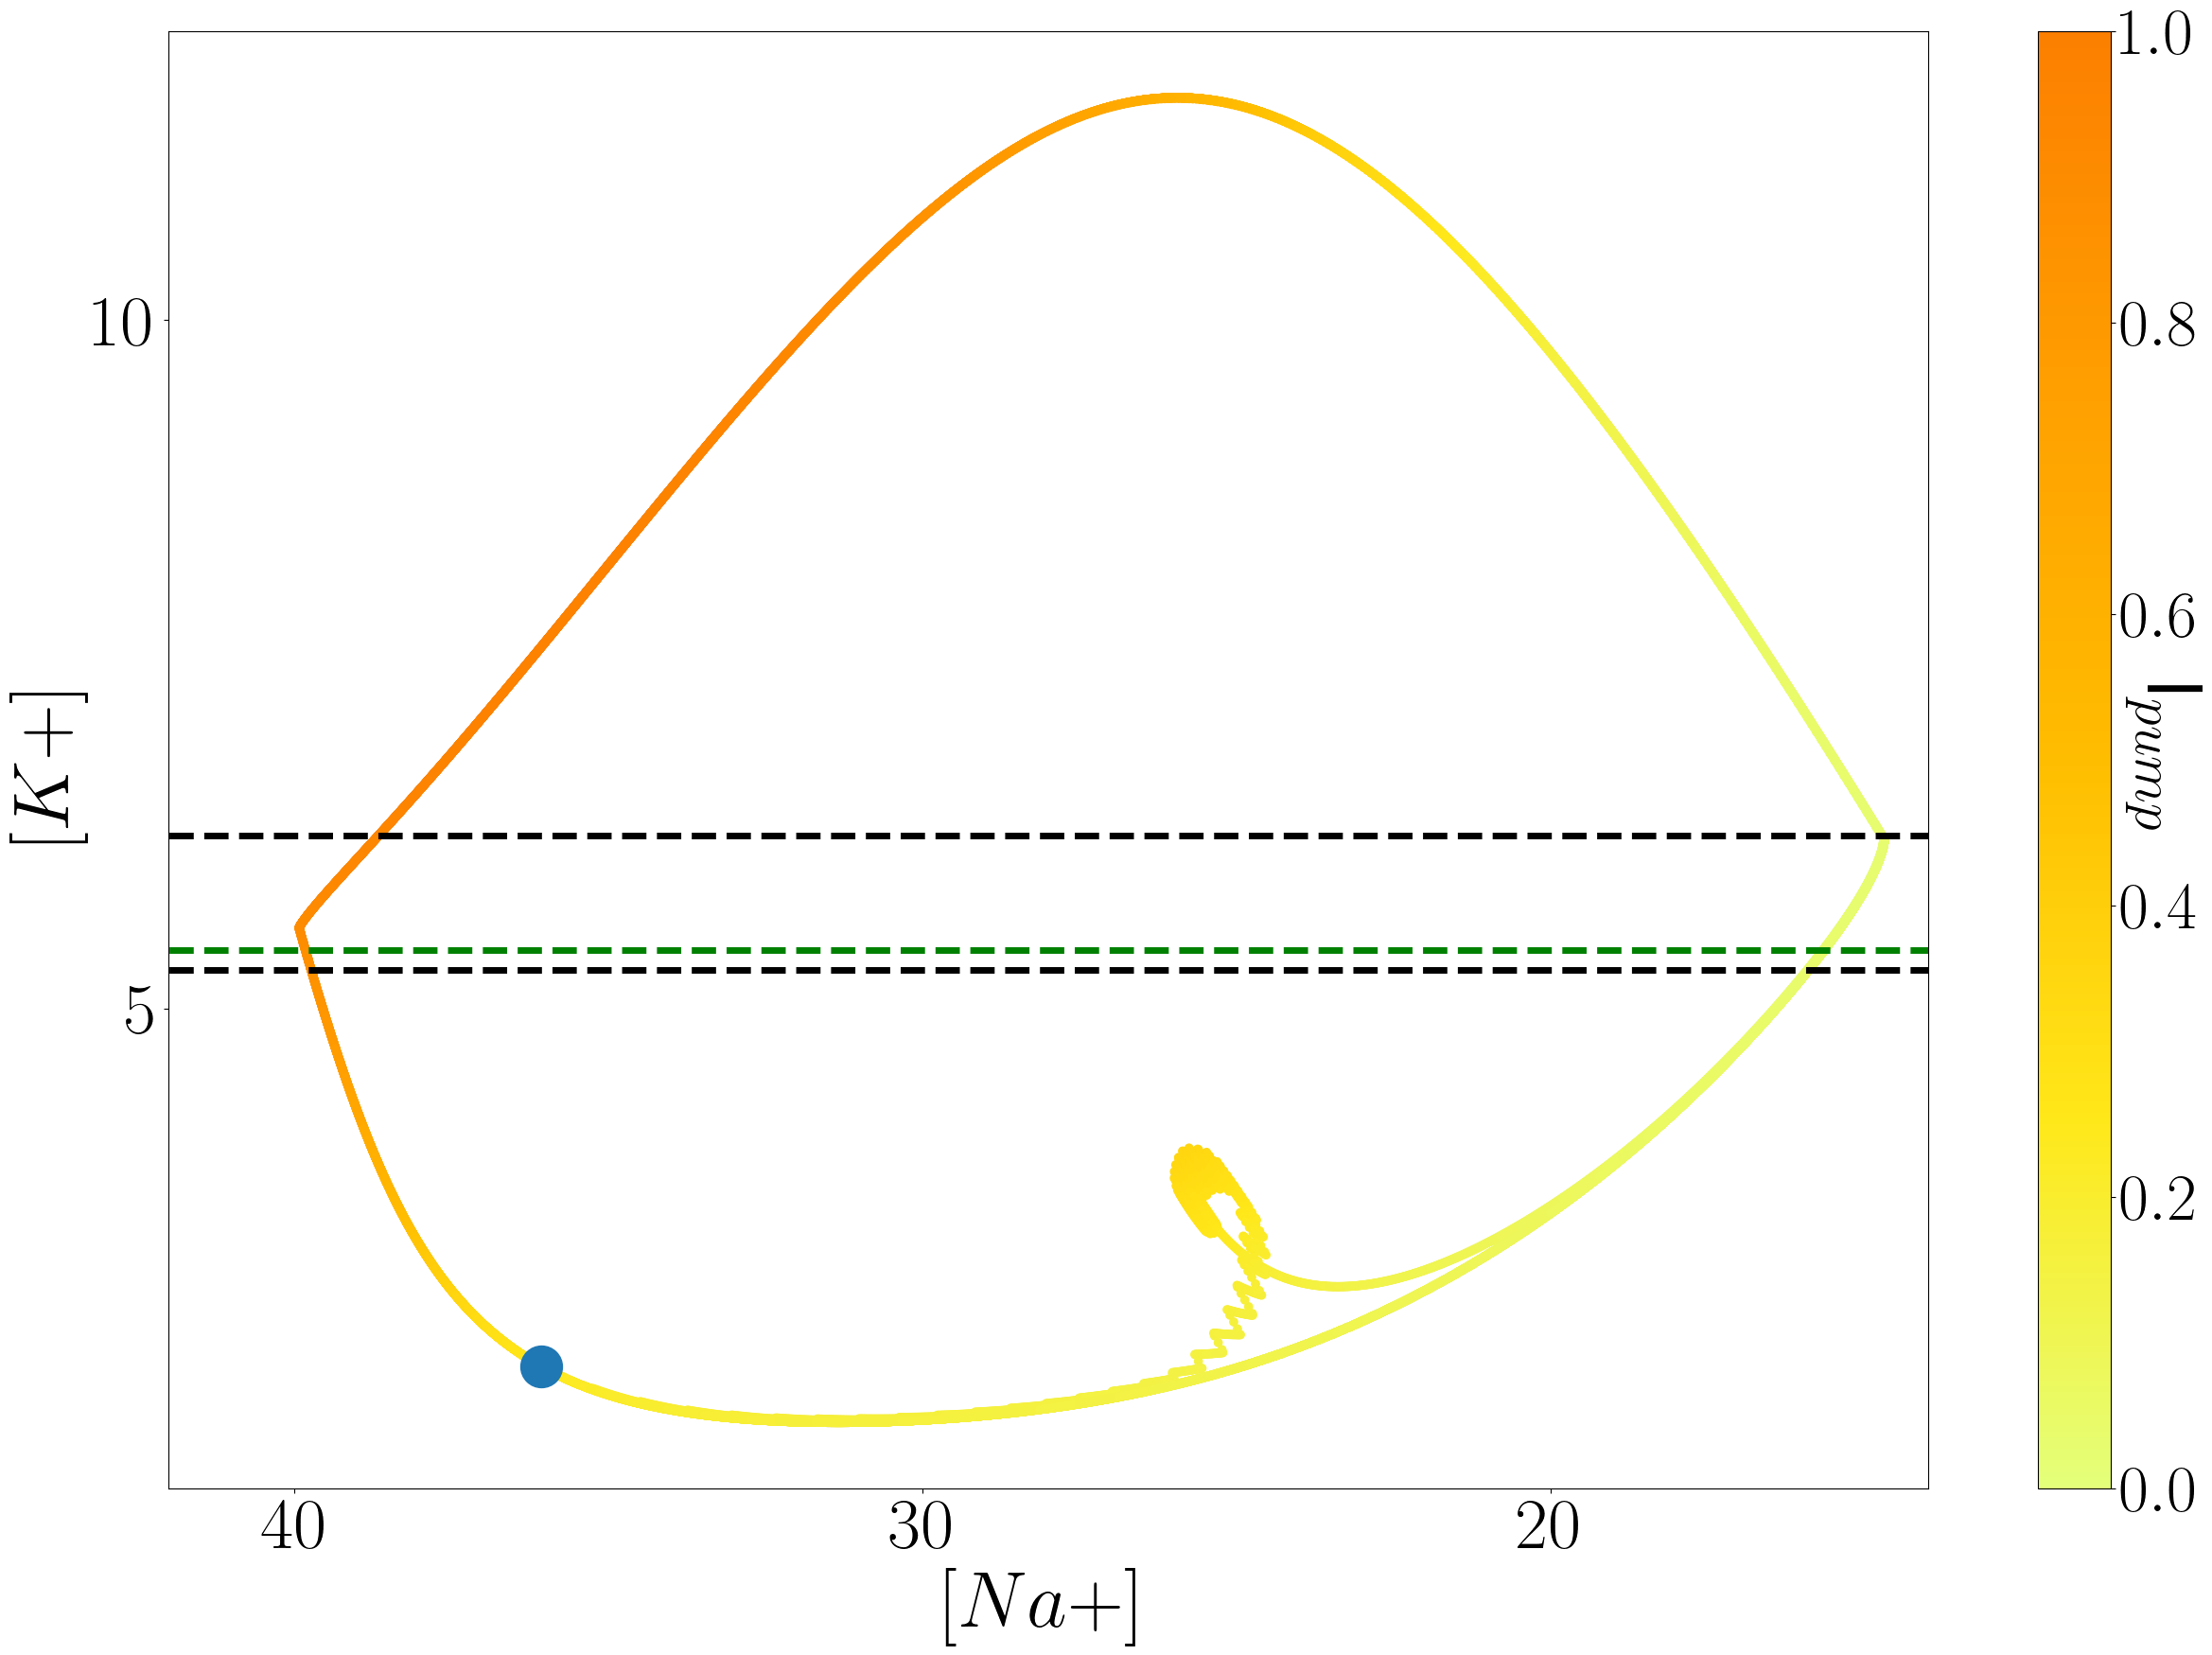

In [53]:
%matplotlib inline

fig = plt.figure(figsize=(30,20)) 
ax = fig.gca()

cmap = plt.get_cmap('Wistia')
norm = mpl.colors.Normalize(vmin=np.min(IPUMP), vmax=np.max(IPUMP))

for i in range(len(NN)):
    plt.scatter(NN[i][108000:][::35], KK[i][108000:][::35], color=cmap(norm(IPUMP[i][108000:][::35])), alpha = 1, )
    plt.scatter(NN[i][VALUES_INI[i]*1000], KK[i][VALUES_INI[i]*1000], s=1000, zorder=20000)


cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),
    ax=plt.gca()
)
cbar.ax.tick_params(labelsize=50)
cbar.ax.set_ylabel('I$_{pump}$', rotation=270, fontsize=60)

plt.plot(np.linspace(0,50,10), np.ones(10)*5.28, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*6.26, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*5.43, 'g--', linewidth=5)



#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")



plt.rc('text', usetex=True)

plt.xlim([14, 42])
#plt.ylim([0,25])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
ax.xaxis.set_inverted(True) 
xLabel = ax.set_xlabel('$[Na+]$', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('$[K+]$',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.savefig('FIG_5_D3.eps', format='eps', dpi=300)
plt.show()

<h1 style="font-size: 22px; color: red;"> V color map :</h1>


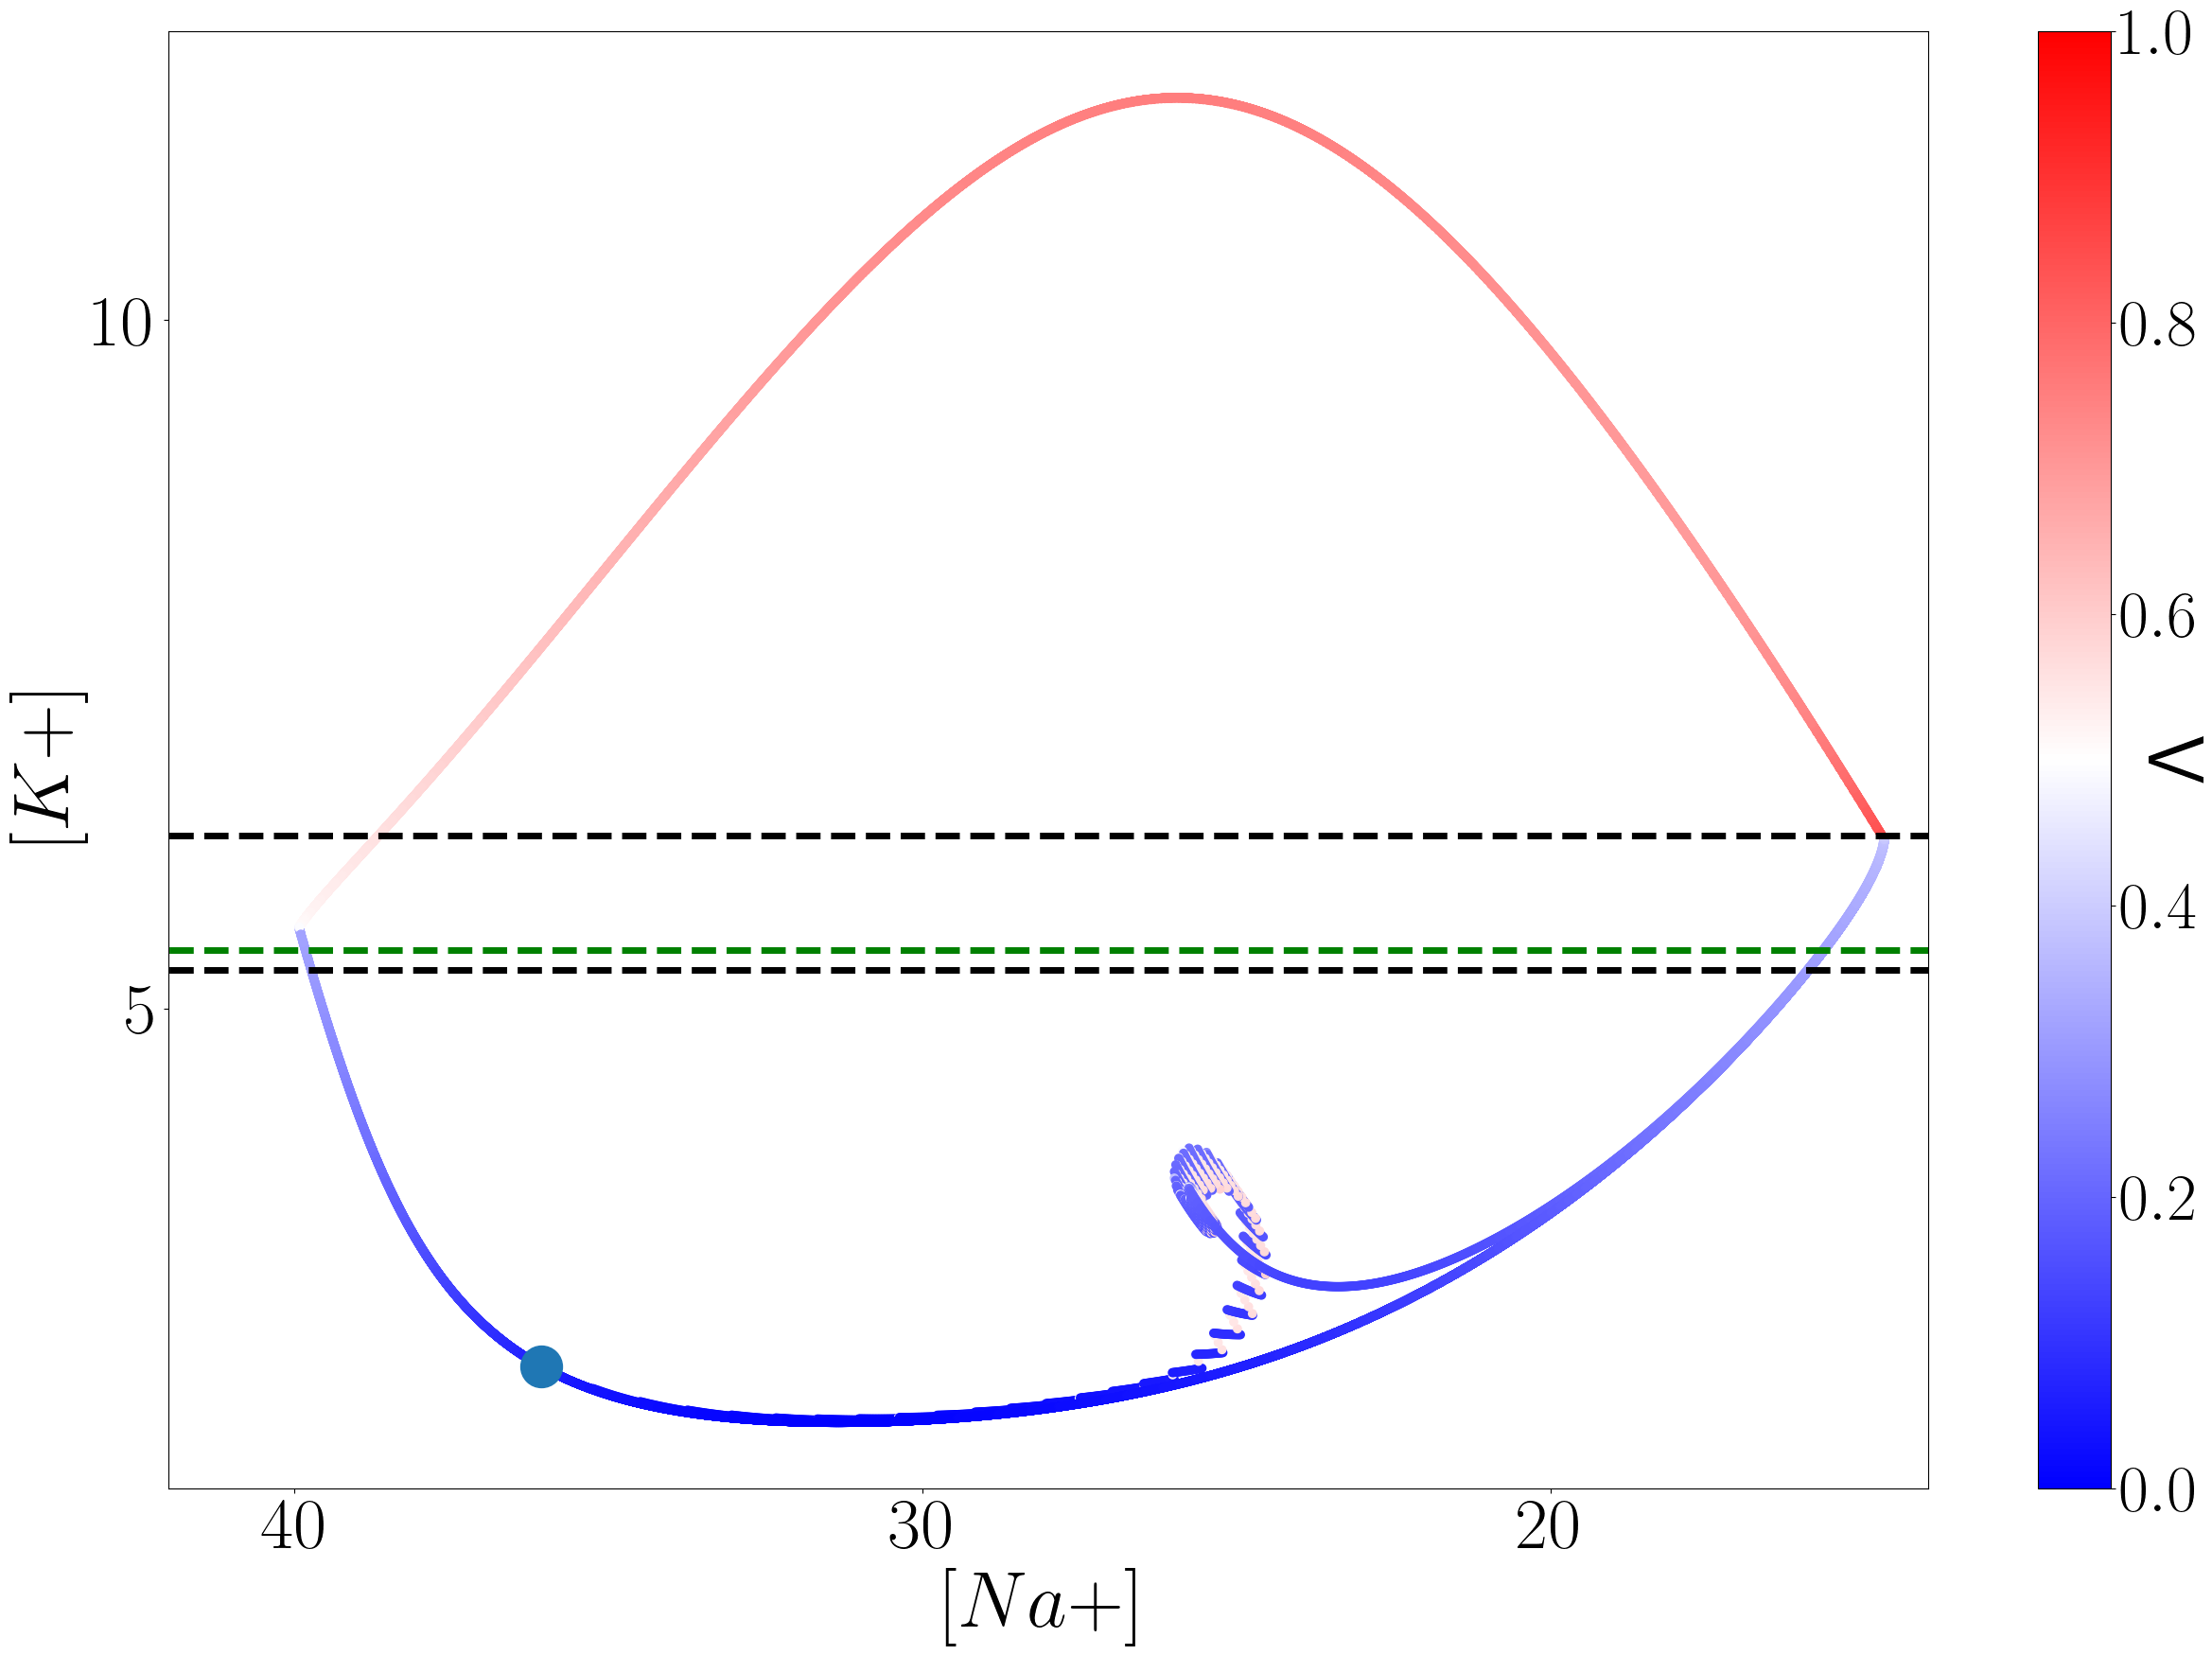

In [55]:
%matplotlib inline

fig = plt.figure(figsize=(30,20)) 
ax = fig.gca()

cmap = plt.get_cmap('bwr')
norm = mpl.colors.Normalize(vmin=np.min(VV), vmax=np.max(VV))

for i in range(len(NN)):
    plt.scatter(NN[i][108000:][::35], KK[i][108000:][::35], color=cmap(norm(VV[i][108000:][::35])), alpha = 1, )
    plt.scatter(NN[i][VALUES_INI[i]*1000], KK[i][VALUES_INI[i]*1000], s=1000, zorder=20000)


cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),
    ax=plt.gca()
)
cbar.ax.tick_params(labelsize=50)
cbar.ax.set_ylabel('V', rotation=270, fontsize=60)

plt.plot(np.linspace(0,50,10), np.ones(10)*5.28, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*6.26, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*5.43, 'g--', linewidth=5)



#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")



plt.rc('text', usetex=True)

plt.xlim([14, 42])
#plt.ylim([0,25])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
ax.xaxis.set_inverted(True) 
xLabel = ax.set_xlabel('$[Na+]$', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('$[K+]$',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.savefig('FIG_5_C3.eps', format='eps', dpi=300)
plt.show()

<h1 style="font-size: 22px; color: red;"> Firing rate color map :</h1>


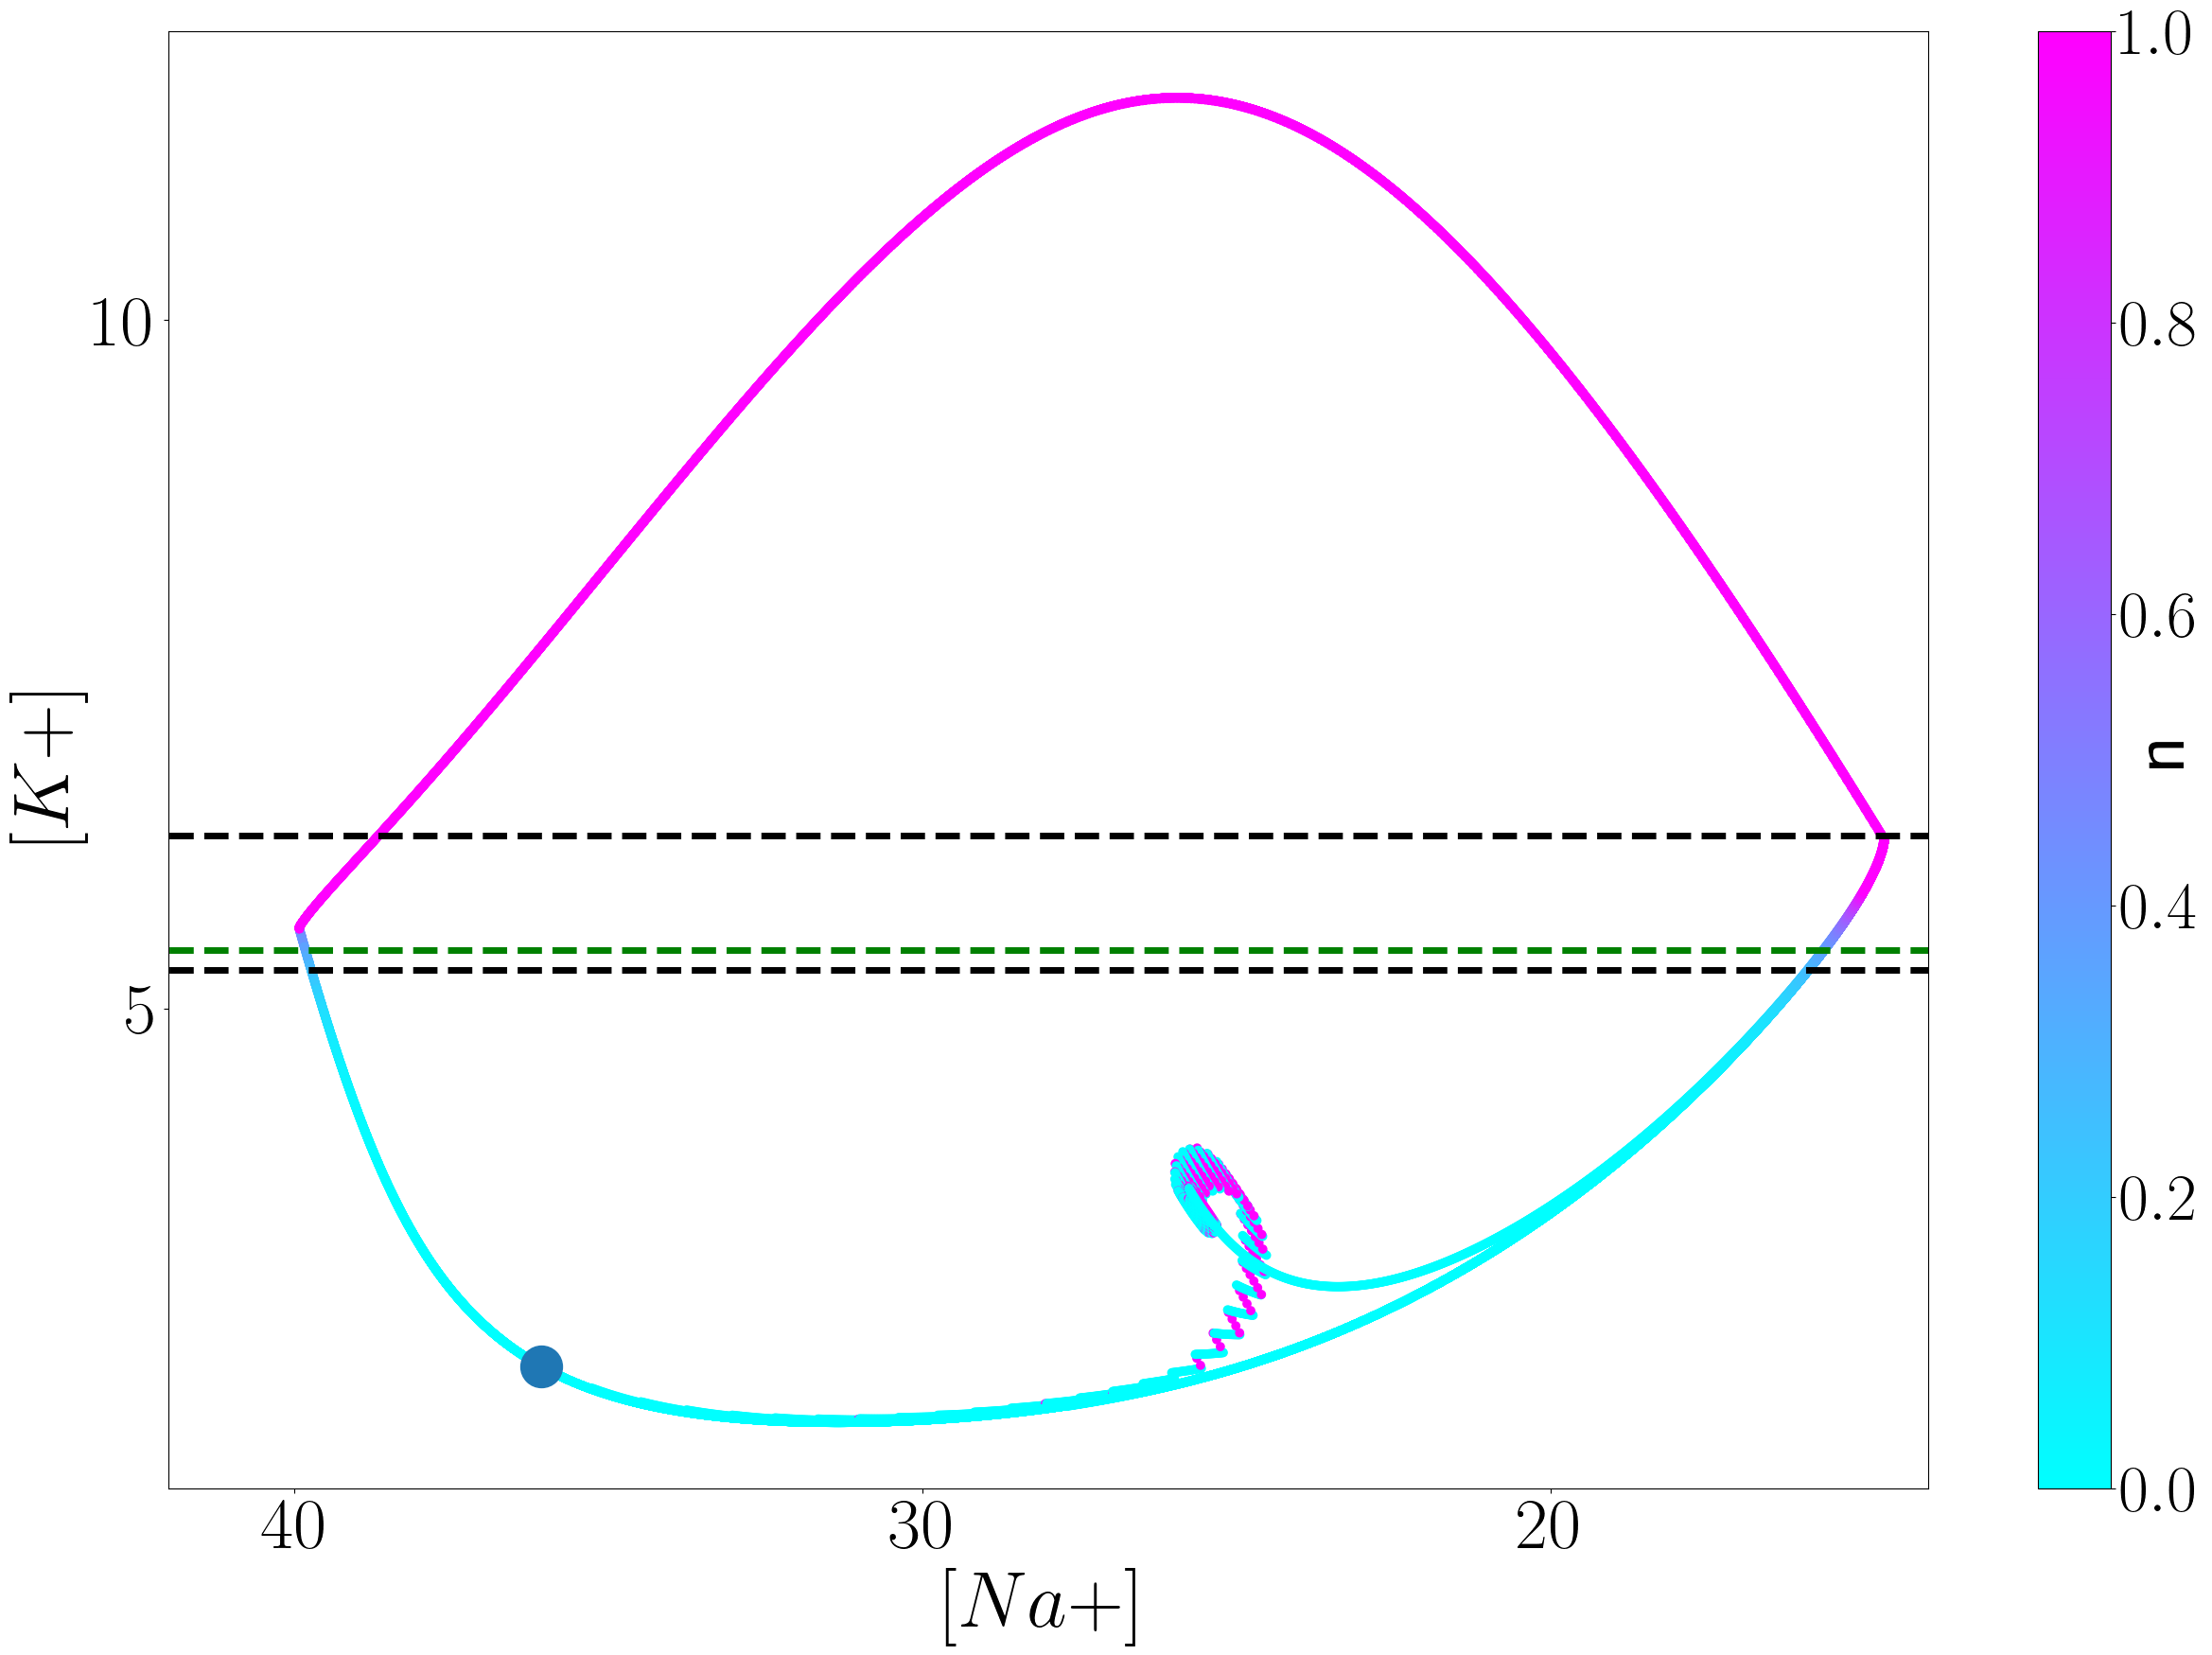

In [57]:
%matplotlib inline

fig = plt.figure(figsize=(30,20)) 
ax = fig.gca()

cmap = plt.get_cmap('cool')
norm = mpl.colors.Normalize(vmin=np.min(FR), vmax=np.max(FR))

for i in range(len(NN)):
    plt.scatter(NN[i][58000:][::35], KK[i][58000:][::35], color=cmap((FR[i][58000:][::35])), alpha = 1, )
    plt.scatter(NN[i][VALUES_INI[i]*1000], KK[i][VALUES_INI[i]*1000], s=1000, zorder=20000)

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),
    ax=plt.gca()
)
cbar.ax.tick_params(labelsize=50)
cbar.ax.set_ylabel('u', rotation=270, fontsize=60)

plt.plot(np.linspace(0,50,10), np.ones(10)*5.28, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*6.26, 'k--', linewidth=5)
plt.plot(np.linspace(0,50,10), np.ones(10)*5.43, 'g--', linewidth=5)



#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")



plt.rc('text', usetex=True)

plt.xlim([14, 42])
#plt.ylim([0,25])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
ax.xaxis.set_inverted(True) 
xLabel = ax.set_xlabel('$[Na+]$', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('$[K+]$',  rotation=90, linespacing=3, fontsize=60)
ax.dist = 10

#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.savefig('FIG_5_E3.eps', format='eps', dpi=300)
plt.show()